In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)

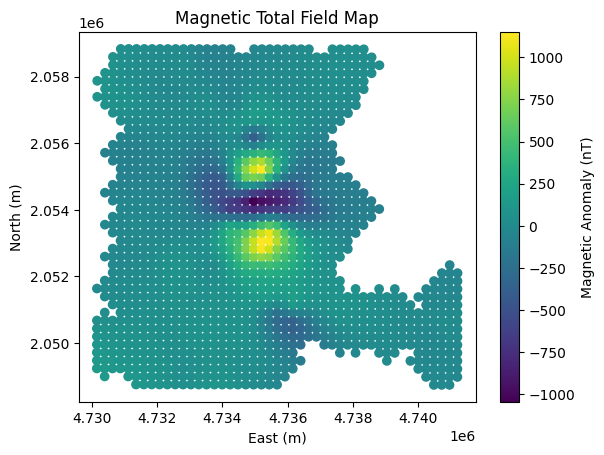

In [3]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [4]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [5]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

coords_magn_min = np.stack([np.min(x_magn), np.min(y_magn)], axis=0).astype(np.float32) 
coords_magn_max = np.stack([np.max(x_magn), np.max(y_magn)], axis=0).astype(np.float32)

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   


Xm_n = (coords_magn[:,0]-coords_magn_min[0])/(coords_magn_max[0]-coords_magn_min[0])
Ym_n = (coords_magn[:,1]-coords_magn_min[1])/(coords_magn_max[1]-coords_magn_min[1])


coords_magn_norm = np.stack([Xm_n, Ym_n], axis=1).astype(np.float32)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(coords_magn_norm), torch.from_numpy(targets_magn))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [6]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
###### Training

iter = 10
activation = "sine"
input_transform = "FF"
num_layers = 15
num_neurons = 128

for i in range(3,iter+1):
    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults
        )

    epochs = 5000

    lr = 1e-4
    max_lr = 2e-4

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_magn),
        epochs=epochs
    )

    loss = []
    for epoch in range(epochs):
        for batch_magn in dl_magn_train:
            optimizer.zero_grad()
            coords_magn, target_magn = batch_magn
            pred_magn = model(coords_magn)
            pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

            loss = criterion(pred_magn_denorm,target_magn)
            loss.backward()
            optimizer.step()
            scheduler.step()

        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f'checkpoints/{i}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth')

        print("Iter: ", i," Epoch: ", epoch, " Loss: ", loss.item())

Iter:  3  Epoch:  0  Loss:  1923546.625
Iter:  3  Epoch:  1  Loss:  1817920.25
Iter:  3  Epoch:  2  Loss:  1470685.0
Iter:  3  Epoch:  3  Loss:  1109856.875
Iter:  3  Epoch:  4  Loss:  974343.4375
Iter:  3  Epoch:  5  Loss:  632670.0625
Iter:  3  Epoch:  6  Loss:  584312.8125
Iter:  3  Epoch:  7  Loss:  399446.09375
Iter:  3  Epoch:  8  Loss:  348257.34375
Iter:  3  Epoch:  9  Loss:  284142.40625
Iter:  3  Epoch:  10  Loss:  325481.46875
Iter:  3  Epoch:  11  Loss:  213472.546875
Iter:  3  Epoch:  12  Loss:  207633.046875
Iter:  3  Epoch:  13  Loss:  210560.546875
Iter:  3  Epoch:  14  Loss:  184181.984375
Iter:  3  Epoch:  15  Loss:  145420.8125
Iter:  3  Epoch:  16  Loss:  146702.484375
Iter:  3  Epoch:  17  Loss:  135712.171875
Iter:  3  Epoch:  18  Loss:  107290.859375
Iter:  3  Epoch:  19  Loss:  90594.046875
Iter:  3  Epoch:  20  Loss:  95163.0234375
Iter:  3  Epoch:  21  Loss:  108117.2890625
Iter:  3  Epoch:  22  Loss:  94781.9921875
Iter:  3  Epoch:  23  Loss:  82984.9453125
I

In [ ]:
activation = "sine"

for i in range(iter+1):

    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults        
        )
    model.load_state_dict(torch.load(f"checkpoints/{1}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

    mse = []
    for batch_magn in dl_magn_val:
        coords_magn, target_magn = batch_magn

        pred_magn = model(coords_magn)
        pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

        coords_magn_denorm = denorm_torch(coords_magn, coords_magn_min, coords_magn_max)

        #print("Coords: ", coords_magn_denorm[0], " Target: ", target_magn[2].item(), " Prediction: ", pred_magn_denorm[2].item())
        #print("MSE: ", criterion(pred_magn_denorm,target_magn).item())

        mse.append(criterion(pred_magn_denorm,target_magn).item())


print("MSE Mean: ", np.mean(mse))

Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  18.6512451171875
MSE:  234.57901000976562


In [10]:
######  agregar code inferencia

#### Relu
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  66.681396484375
###MSE:  457.57025146484375


#### Sine
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  36.4681396484375
###MSE:  218.6893768310547

#### Wire
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  35.3487548828125
###MSE:  221.7586669921875